# Effect of synaptic weights on various models of decision making

To better understand the decision making process and how it is adapted with synaptic plasticity, we can start by seeing how it behaves in the idealised versions, particularly the [Mutual-Inhibition](#The-Mutual-Inhibition-Model) and [Pooled-Inhibition](#The-Pooled-Inhibition-Model) models.

In [1]:
# setup
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from graphviz import Digraph
from IPython.core.pylabtools import figsize

figsize(12.5, 6)

## The Drift-Diffusion Model

The model is described by:
$$
dx_t = A dt + cdW_t, \quad x_0 = 0
$$

In [2]:
def run_ddm(
    m_A, c, x_0=0, s_A=0,
    runtime=None, threshold=None,
    dt=0.1
):
    assert s_A >= 0
    assert c >= 0
    assert runtime is not None or threshold is not None
    if runtime is None:
        runtime = np.inf
    elif threshold is None:
        threshold = np.inf
    if s_A == 0:
        A = m_A
    else:
        A = m_A + np.random.randn()*s_A
    t = 0
    x = [x_0]
    while t < runtime and np.abs(x[-1]) < np.abs(threshold):
        dx = A*dt + c * np.sqrt(dt) * np.random.randn()
        x_new = x[-1] + dx
        x.append(x_new)
        t += dt
    return x, t

In [3]:
num_simulations = 10000
decision_times = []
right_answers = []
threshold = 1.5
runtime = None #100
dt = 0.01
for i in range(num_simulations):
    x, T = run_ddm(2, 1, 0, 0, runtime, threshold, dt)
    t = np.arange(len(x))*dt
    if x[-1] > 0:
        right_answers.append(1)
    else:
        right_answers.append(0)
    decision_times.append(T)
    
decision_times = np.array(decision_times)
right_answers = np.array(right_answers)

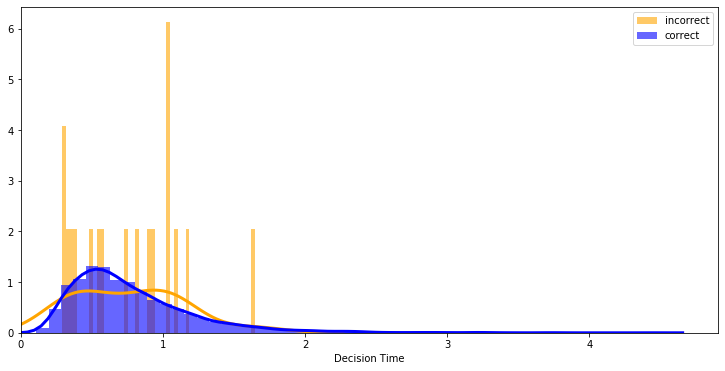

In [4]:
sns.distplot(
    decision_times[right_answers==0], hist=True, kde=True,
    bins=50, color='orange', label='incorrect',
    hist_kws={'alpha': 0.6},
    kde_kws={'linewidth': 3}
)
sns.distplot(
    decision_times[right_answers==1], hist=True, kde=True,
    bins=50, color='blue', label='correct',
    hist_kws={'alpha': 0.6},
    kde_kws={'linewidth': 3}
)
plt.legend(loc='upper right')
xlim = plt.xlim()
plt.xlim([0.0, xlim[1]])
plt.xlabel('Decision Time')
plt.show()

# plt.plot(t, x)
# plt.hlines([-threshold, threshold], t[0], t[-1], linestyles='--', alpha=0.9)
# plt.show()

## The Ornstein-Uhlenbeck Process Model
The model is described by:
$$
dx_t = (\lambda x_t + A) dt + cdW_t, \quad x_0 = 0
$$

In [10]:
def run_oup(
    m_A, c, lambda_=0.0, x_0=0, s_A=0,
    runtime=None, threshold=None,
    dt=0.1
):
    assert s_A >= 0
    assert c >= 0
    assert runtime is not None or threshold is not None
    if runtime is None:
        runtime = np.inf
    elif threshold is None:
        threshold = np.inf
    if s_A == 0:
        A = m_A
    else:
        A = m_A + np.random.randn()*s_A
    t = 0
    x = [x_0]
    while t < runtime and np.abs(x[-1]) < np.abs(threshold):
        dx = (x[-1]*lambda_ + A)*dt + c * np.sqrt(dt) * np.random.randn()
        x_new = x[-1] + dx
        x.append(x_new)
        t += dt
    return x, t

In [11]:
num_simulations = 10000
decision_times = []
right_answers = []
threshold = 1.5
runtime = None #100
lambda_ = -1.0
dt = 0.01
for i in range(num_simulations):
    x, T = run_oup(2, 1, lambda_, 0, 0, runtime, threshold, dt)
    t = np.arange(len(x))*dt
    if x[-1] > 0:
        right_answers.append(1)
    else:
        right_answers.append(0)
    decision_times.append(T)
    
decision_times = np.array(decision_times)
right_answers = np.array(right_answers)

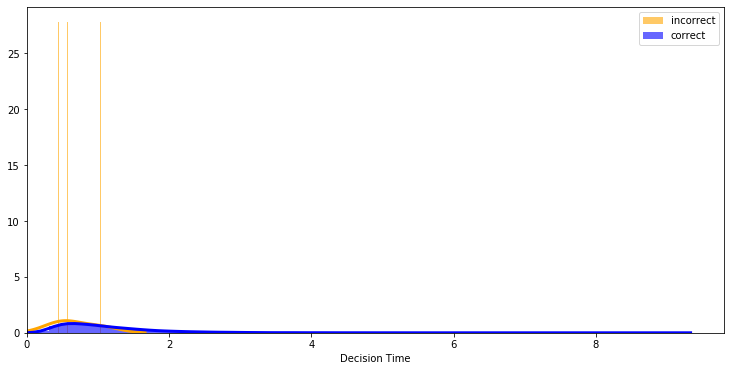

In [12]:
sns.distplot(
    decision_times[right_answers==0], hist=True, kde=True,
    bins=50, color='orange', label='incorrect',
    hist_kws={'alpha': 0.6},
    kde_kws={'linewidth': 3}
)
sns.distplot(
    decision_times[right_answers==1], hist=True, kde=True,
    bins=50, color='blue', label='correct',
    hist_kws={'alpha': 0.6},
    kde_kws={'linewidth': 3}
)
plt.legend(loc='upper right')
xlim = plt.xlim()
plt.xlim([0.0, xlim[1]])
plt.xlabel('Decision Time')
plt.show()

## The Mutual-Inhibition Model

The model is described by:
$$
\begin{align}
    dy^1_t &= (w_+ y^1_t - w_- y^2_t + A^1) dt + cdW^1_t, \quad y^1_t = 0\\
    dy^2_t &= (w_+ y^2_t - w_- y^1_t + A^2) dt + cdW^2_t, \quad y^2_t = 0
\end{align}
$$

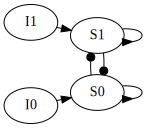

In [74]:
# draw models
from graphviz import Digraph

dot_MI = Digraph(engine="fdp", filename='MI_graph.gv',format='png')
num_inputs = 2
for i in range(num_inputs):
    dot_MI.node(str(i), _attributes=dict(label='I'+str(i), pos=f"0,{i}"))
    dot_MI.node(str(i + num_inputs), _attributes=dict(label='S'+str(i), pos=f"1,{i}"))
    dot_MI.edge(str(i), str(i + num_inputs))
    dot_MI.edge(str(i + num_inputs), str(i + num_inputs), arrowhead='inv')
for i in range(num_inputs):
    for j in range(num_inputs):
        if i != j:
            dot_MI.edge(str(i+num_inputs), str(j + num_inputs), arrowhead='dot')
dot_MI.render()  # saves graph
dot_MI

In [131]:
# TODO: CHECK
def run_mi(
    w_plus, w_minus, A_1, A_2, c, 
    y_1_0=0, y_2_0=0,
    runtime=None, threshold=None,
    dt=0.1
):
    if runtime is None:
        runtime = np.inf
    elif threshold is None:
        threshold = np.inf
    
    t = 0
    y_1 = [y_1_0]
    y_2 = [y_2_0]
    while t < runtime and y_1[-1] < np.abs(threshold) and y_2[-1] < np.abs(threshold):
        dy_1 = (y_1[-1]*w_plus - y_2[-1]*w_minus + A_1)*dt + c*np.sqrt(dt)*np.random.randn()
        dy_2 = (y_2[-1]*w_plus - y_1[-1]*w_minus + A_2)*dt + c*np.sqrt(dt)*np.random.randn()
        y_1_new = max(y_1[-1] + dy_1, 0)
        y_2_new = max(y_2[-1] + dy_2, 0)
        y_1.append(y_1_new)
        y_2.append(y_2_new)
        t += dt
    return y_1, y_2, t

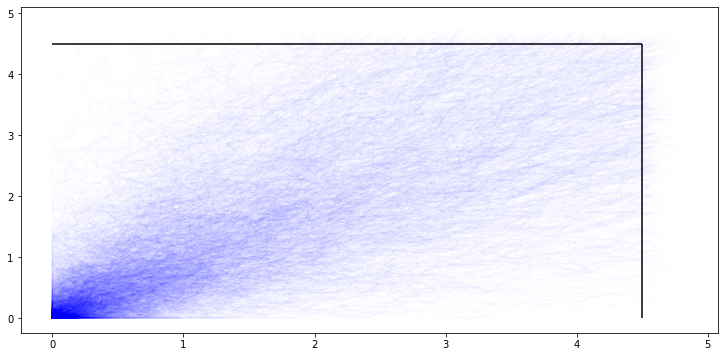

In [135]:
threshold=4.5
w_plus=1.7
w_minus=0.1
A_1=3
A_2=3
c=1

alpha = 0.01
num_simulations = 1000

min_y1 = 0
min_y2 = 0
y1_final = []
y2_final = []
for i in range(num_simulations):
    y_1, y_2, t = run_mi(
        w_plus, w_minus, A_1, A_2, c,
        threshold=threshold, dt=0.01
    )
    y1_final.append(y_1[-1])
    y2_final.append(y_2[-1])
    min_y1 = min(min_y1, *y_1)
    min_y2 = min(min_y2, *y_2)
    plt.plot(y_1, y_2, alpha=alpha, color='blue')
plt.vlines(threshold, min_y2, threshold)
plt.hlines(threshold, min_y1, threshold)
plt.show()

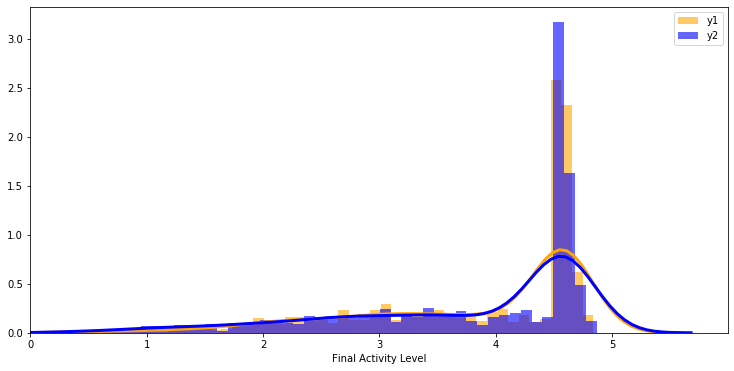

In [136]:
sns.distplot(
    y1_final, hist=True, kde=True,
    bins=50, color='orange', label='y1',
    hist_kws={'alpha': 0.6},
    kde_kws={'linewidth': 3}
)
sns.distplot(
    y2_final, hist=True, kde=True,
    bins=50, color='blue', label='y2',
    hist_kws={'alpha': 0.6},
    kde_kws={'linewidth': 3}
)
plt.legend(loc='upper right')
xlim = plt.xlim()
plt.xlim([0.0, xlim[1]])
plt.xlabel('Final Activity Level')
plt.show()

## The Pooled-Inhibition Model

TODO: Derive/work through equations to relate Wang model to Bogacz simplification.

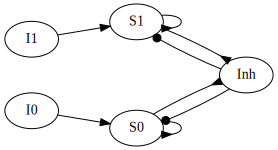

In [2]:
from graphviz import Digraph

dot_PI = Digraph(engine="neato", filename='PI_graph.gv', format='png')
num_inputs = 2
for i in range(num_inputs):
    dot_PI.node(str(i), _attributes=dict(label='I'+str(i), pos=f"0,{i}!"))
    dot_PI.node(str(i + num_inputs), _attributes=dict(label='S'+str(i), pos=f"1.5,{i}"))
    dot_PI.edge(str(i), str(i + num_inputs))
    dot_PI.edge(str(i + num_inputs), str(i + num_inputs), arrowhead='inv')
dot_PI.node(str(2*num_inputs + 1), _attributes=dict(label='Inh', pos=f"3,{0.5}!"))
for i in range(num_inputs):
    dot_PI.edge(str(i+num_inputs), str(2*num_inputs + 1), arrowhead='inv')
    dot_PI.edge(str(2*num_inputs + 1), str(i+num_inputs), arrowhead='dot')
dot_PI.render()
dot_PI

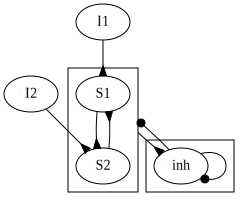

In [63]:
from graphviz import Digraph

g = Digraph('G', filename='cluster_edge.gv')
g.attr(compound='true')

# with g.subgraph(name='cluster1') as c:
#     c.node('I1')
#     c.node('I2')

g.node('I1')
g.node('I2')

g.node('S1')
g.node('S2')

with g.subgraph(name='cluster2') as c:
    c.node('inh')
    c.edge('inh', 'inh', arrowhead='dot')

with g.subgraph(name='cluster0') as c:
    c.edge('S2', 'S1', arrowhead='inv')
    c.edge('S1', 'S2', arrowhead='inv')

g.edge('I2', 'S2', arrowhead='inv')
g.edge('I1', 'S1', arrowhead='inv')

g.edge('S1', 'inh', ltail='cluster0', arrowhead='inv')
g.edge('inh', 'S1', lhead='cluster0', arrowhead='dot')
# g.edge('d', 'e')
# g.edge('d', 'e', ltail='cluster0', lhead='cluster1')
# g.edge('c', 'e', ltail='cluster0')


g

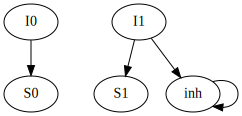

In [24]:
from graphviz import Digraph

dot_wang = Digraph(filename='PI_graph.gv', format='png')  #engine="neato"
dot_wang.attr(compound='true')

# for i in range(2):
#     dot_wang.node(str(i), _attributes=dict(label='I'+str(i)))
#     dot_wang.node(str(i+2), _attributes=dict(label='S'+str(i)))
#     dot_wang.edge(str(i), str(i+2))

with dot_wang.subgraph(name='Exc') as c:
    edges = []
    for i in range(2):
        edges.append(('I'+str(i), 'S'+str(i)))
    c.edges(edges)

with dot_wang.subgraph(name='Inh') as c:
    c.edges([('inh', 'inh')])
    
dot_wang.edge('I'+str(i), 'inh', ltail='Exc', lhead='Inh')
# dot_wang.edge('Exc', 'Inh')
# dot_wang.edge('c', 'g', ltail='cluster0', lhead='cluster1')
    
dot_wang
# num_inputs = 2
# for i in range(num_inputs):
#     dot_PI.node(str(i), _attributes=dict(label='I'+str(i), pos=f"0,{i}!"))
#     dot_PI.node(str(i + num_inputs), _attributes=dict(label='S'+str(i), pos=f"1.5,{i}"))
#     dot_PI.edge(str(i), str(i + num_inputs))
#     dot_PI.edge(str(i + num_inputs), str(i + num_inputs), arrowhead='inv')
# dot_PI.node(str(2*num_inputs + 1), _attributes=dict(label='Inh', pos=f"3,{0.5}!"))
# for i in range(num_inputs):
#     dot_PI.edge(str(i+num_inputs), str(2*num_inputs + 1), arrowhead='inv')
#     dot_PI.edge(str(2*num_inputs + 1), str(i+num_inputs), arrowhead='dot')
# dot_PI.render()
# dot_PI